# Start

* Should i scale my data? Yes, minmax scaler
* Most of these features don't seem to be correlating with the output. Should i drop them? No don't drop them, they may have non linear relationship. use feature importance function to check their importance
* what should i do with the cc_num? dropped
* will the time be able to pass through the model? or should i use unix time?
* how to handle categorical values? Frequency encoding? Target Encoding? Label Encoding?
* How is UI going to pass the categorical data to the model? import the encoder using joblib, same with your scaler

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree

In [79]:

df = pd.read_csv('fraudTrain.csv')
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,01/01/2019 0:00,2.700000e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",09/03/1988,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,01/01/2019 0:00,6.300000e+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,21/06/1978,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,01/01/2019 0:00,3.890000e+13,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,19/01/1962,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,01/01/2019 0:01,3.530000e+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,12/01/1967,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,01/01/2019 0:03,3.760000e+14,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,28/03/1986,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0



* cc_num: 2.700000e+15. Likely represents a credit card number. The scientific notation suggests it’s stored as a float, but it's better treated as a string to avoid precision errors.

* zip : 28654.	Likely the ZIP code or postal code associated with the transaction or cardholder’s billing address. Useful for identifying fraud patterns based on geographic data.
* trans_num : 0b242abb623afc578575680df30655b9.	Likely a unique transaction ID — often alphanumeric for tracking individual transactions. This is useful for identifying specific entries but shouldn't be used as a predictive feature.

* unix_time : 1325376018. 	Represents the timestamp of the transaction in Unix time (seconds since Jan 1, 1970). Converting this into readable date formats (e.g., datetime) can reveal valuable insights like transaction patterns, time-of-day trends, etc

In [80]:
df['is_fraud'].value_counts()

is_fraud
0    324629
1      2346
Name: count, dtype: int64

In [81]:
percentage_fraud = (2346/324629)*100
percentage_fraud

0.7226711107140767

### visualize the variation in the target data

<Axes: xlabel='is_fraud'>

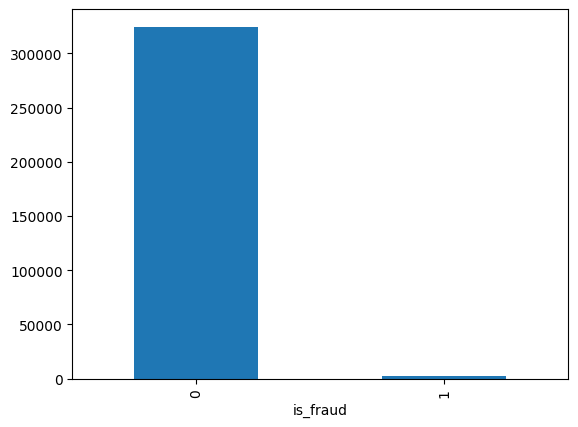

In [82]:
df['is_fraud'].value_counts().plot(kind='bar')

### Clean the data

In [83]:
df.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [84]:
print(df.duplicated().sum())

0


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326975 entries, 0 to 326974
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  326975 non-null  object 
 1   cc_num                 326975 non-null  float64
 2   merchant               326975 non-null  object 
 3   category               326975 non-null  object 
 4   amt                    326975 non-null  float64
 5   first                  326975 non-null  object 
 6   last                   326975 non-null  object 
 7   gender                 326975 non-null  object 
 8   street                 326975 non-null  object 
 9   city                   326975 non-null  object 
 10  state                  326975 non-null  object 
 11  zip                    326975 non-null  int64  
 12  lat                    326975 non-null  float64
 13  long                   326975 non-null  float64
 14  city_pop               326975 non-nu

### Data preprocessing

In [86]:
# convert data type
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format="%d/%m/%Y %H:%M", errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326975 entries, 0 to 326974
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  326975 non-null  datetime64[ns]
 1   cc_num                 326975 non-null  float64       
 2   merchant               326975 non-null  object        
 3   category               326975 non-null  object        
 4   amt                    326975 non-null  float64       
 5   first                  326975 non-null  object        
 6   last                   326975 non-null  object        
 7   gender                 326975 non-null  object        
 8   street                 326975 non-null  object        
 9   city                   326975 non-null  object        
 10  state                  326975 non-null  object        
 11  zip                    326975 non-null  int64         
 12  lat                    326975 non-null  floa

### feature engineering

In [87]:
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.day_of_week
df['is_weekend'] = (df['trans_date_trans_time'].dt.day_of_week >=5).astype(int)

In [88]:
numeric = ['trans_date_trans_time', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'hour', 'day_of_week', 'is_weekend']

df_numeric = df[numeric]
df_numeric.head()

,trans_date_trans_time,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day_of_week,is_weekend
0,2019-01-01 00:00:00,2.700000e+15,4.97,28654,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,0
1,2019-01-01 00:00:00,6.300000e+11,107.23,99160,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,0
2,2019-01-01 00:00:00,3.890000e+13,220.11,83252,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,0
3,2019-01-01 00:01:00,3.530000e+15,45.00,59632,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,0
4,2019-01-01 00:03:00,3.760000e+14,41.96,24433,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,0


In [89]:
df_numeric['hour'].value_counts()

hour
22    16989
23    16854
18    16755
19    16633
16    16558
17    16509
14    16481
20    16464
13    16445
21    16443
15    16352
12    16334
1     10946
3     10918
10    10784
6     10726
0     10687
2     10677
4     10623
8     10594
11    10588
7     10583
5     10523
9     10509
Name: count, dtype: int64

In [90]:
df_numeric['is_weekend'].value_counts()

is_weekend
0    214686
1    112289
Name: count, dtype: int64

In [91]:
df_numeric['day_of_week'].value_counts()

day_of_week
0    63757
6    62132
5    50157
1    42483
4    38403
3    37467
2    32576
Name: count, dtype: int64

### Check correlation

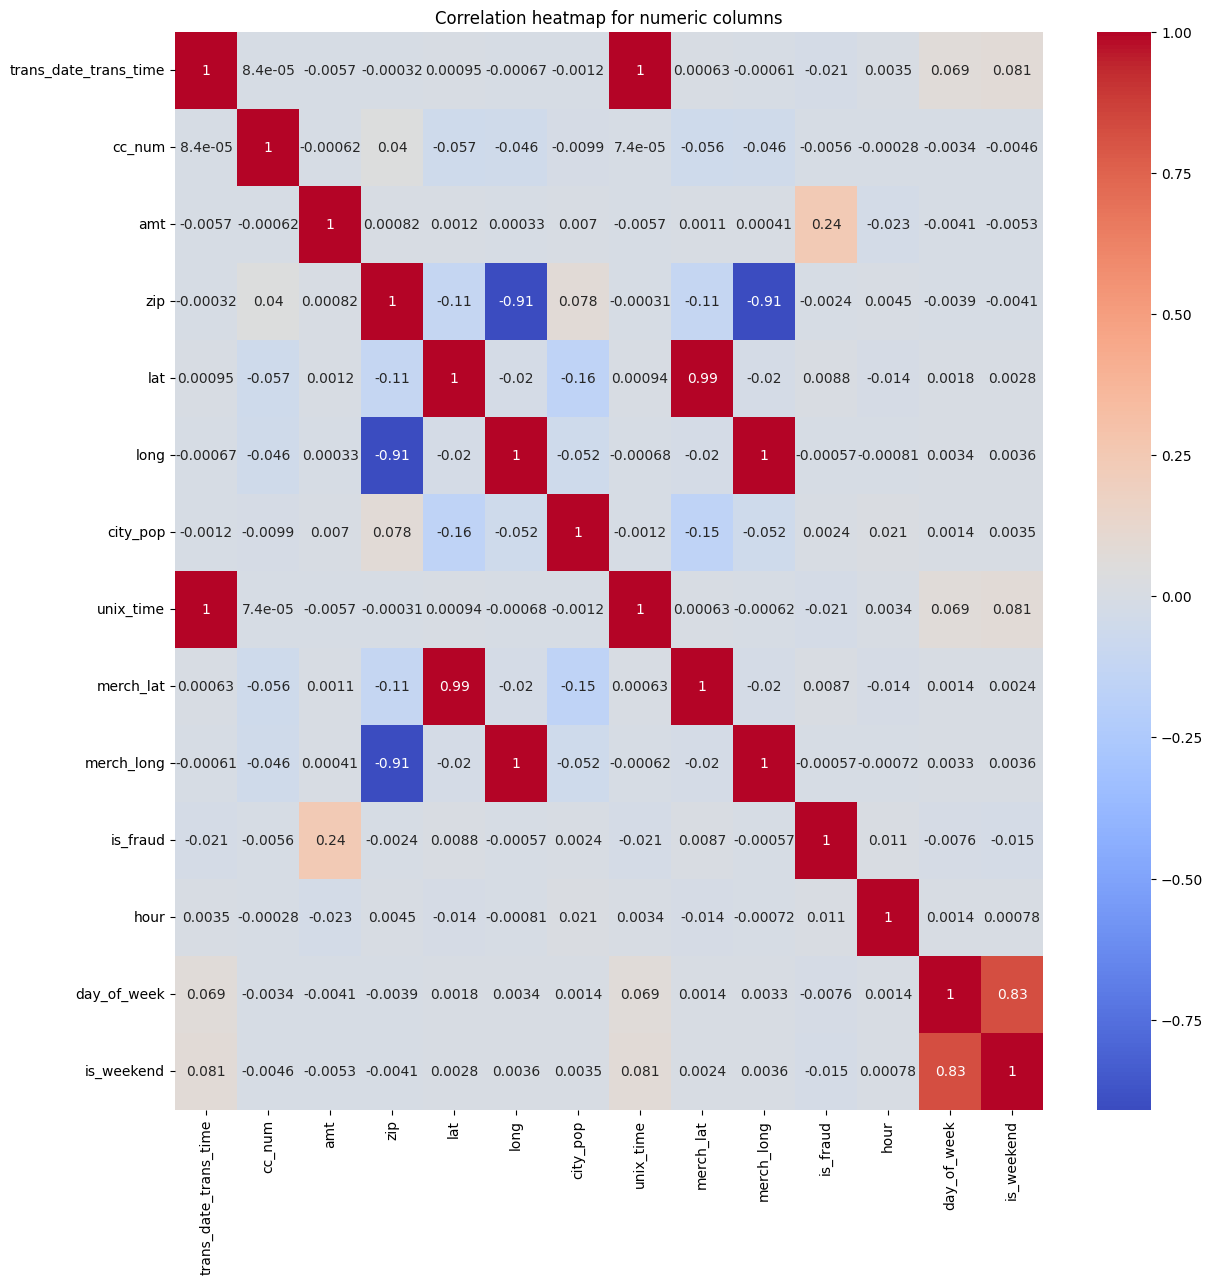

In [92]:
# feature correlation plot

plt.figure(figsize = (14, 14))
plt.title('Credit card fraud detection correlation plot')

corr = df_numeric.corr()
# sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths= .1, cmap='Reds')
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap for numeric columns')
plt.show()

some of the features are repeating, we will drop them for better understanding of correlations

In [93]:
new_df = df_numeric.drop(columns=['cc_num','unix_time', 'lat', 'long'])
new_df.head()

,trans_date_trans_time,amt,zip,city_pop,merch_lat,merch_long,is_fraud,hour,day_of_week,is_weekend
0,2019-01-01 00:00:00,4.97,28654,3495,36.011293,-82.048315,0,0,1,0
1,2019-01-01 00:00:00,107.23,99160,149,49.159047,-118.186462,0,0,1,0
2,2019-01-01 00:00:00,220.11,83252,4154,43.150704,-112.154481,0,0,1,0
3,2019-01-01 00:01:00,45.00,59632,1939,47.034331,-112.561071,0,0,1,0
4,2019-01-01 00:03:00,41.96,24433,99,38.674999,-78.632459,0,0,1,0


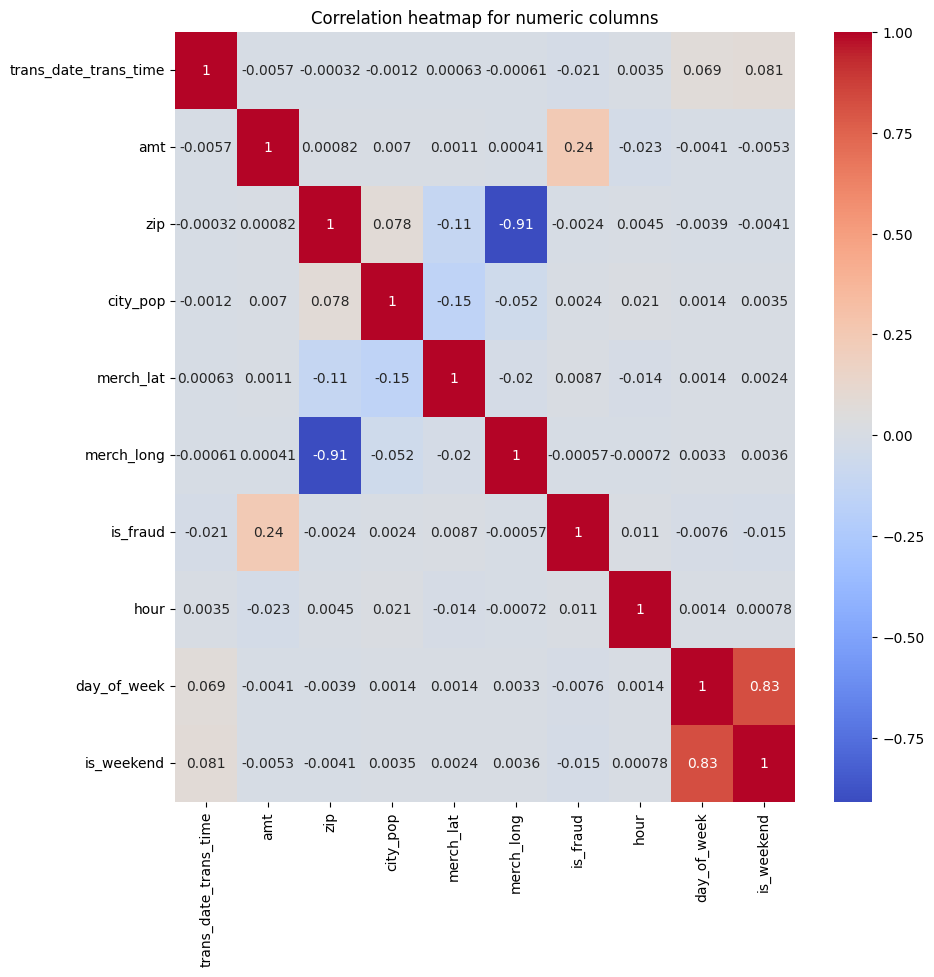

In [94]:

plt.figure(figsize = (10, 10))
plt.title('Credit card fraud detection correlation plot')

corr = new_df.corr()
# sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths= .1, cmap='Reds')
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap for numeric columns')
plt.show()

## Handling categorical features

In [95]:
df['city'].value_counts()

city
Birmingham     1408
Meridian       1369
Utica          1302
Phoenix        1296
San Antonio    1275
               ... 
Crouse            8
Gaines            8
Vacaville         7
Chattanooga       7
Claypool          7
Name: count, Length: 859, dtype: int64

In [96]:
df['merchant'].value_counts()

merchant
fraud_Kilback LLC                        1105
fraud_Cormier LLC                         941
fraud_Schumm PLC                          931
fraud_Dickinson Ltd                       876
fraud_Boyer PLC                           862
                                         ... 
fraud_Hahn, Douglas and Schowalter        183
fraud_Ritchie, Oberbrunner and Cremin     182
fraud_Kessler Group                       180
fraud_Jerde-Hermann                       178
fraud_Hodkiewicz, Prohaska and Paucek     172
Name: count, Length: 693, dtype: int64

In [97]:
df['category'].value_counts() # size 14

category
gas_transport     33122
grocery_pos       31334
home              30949
shopping_pos      29470
kids_pets         28382
shopping_net      24768
entertainment     23643
food_dining       23261
personal_care     22832
health_fitness    21771
misc_pos          19894
misc_net          15945
grocery_net       11418
travel            10186
Name: count, dtype: int64

In [98]:
df['job'].value_counts().size

481

In [99]:
df['state'].value_counts().size

51

In [100]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,day_of_week,is_weekend
0,2019-01-01 00:00:00,2.700000e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,"Psychologist, counselling",09/03/1988,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1,0
1,2019-01-01 00:00:00,6.300000e+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,Special educational needs teacher,21/06/1978,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1,0
2,2019-01-01 00:00:00,3.890000e+13,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,Nature conservation officer,19/01/1962,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1,0
3,2019-01-01 00:01:00,3.530000e+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,Patent attorney,12/01/1967,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1,0
4,2019-01-01 00:03:00,3.760000e+14,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,Dance movement psychotherapist,28/03/1986,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1,0


In [101]:
df = df.drop(columns=['cc_num','unix_time', 'lat', 'long', 'first', 'last', 'street', 'dob', 'city', 'state', 'job', 'gender'])
df.head()

,trans_date_trans_time,merchant,category,amt,zip,city_pop,trans_num,merch_lat,merch_long,is_fraud,hour,day_of_week,is_weekend
0,2019-01-01 00:00:00,"fraud_Rippin, Kub and Mann",misc_net,4.97,28654,3495,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,0,1,0
1,2019-01-01 00:00:00,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,99160,149,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,0,1,0
2,2019-01-01 00:00:00,fraud_Lind-Buckridge,entertainment,220.11,83252,4154,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,0,1,0
3,2019-01-01 00:01:00,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,59632,1939,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,0,1,0
4,2019-01-01 00:03:00,fraud_Keeling-Crist,misc_pos,41.96,24433,99,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,0,1,0


## Label Encoding
 
We are going to use frequency encoding for encoding our data, because we have to many data for one hot encoding, can't use label encoding for nominal data

In [103]:
# Frequency encoding during training
for col in ['merchant', 'category']:
    freq_map = df[col].value_counts().to_dict()
    df[f'{col}_encoded'] =  df[col].map(freq_map)

# Save the mapping for later use in your GUI
import pickle
with open('freq_encoding_maps.pkl', 'wb') as f:
    pickle.dump(freq_map, f)


In [104]:
df.head()

,trans_date_trans_time,merchant,category,amt,zip,city_pop,trans_num,merch_lat,merch_long,is_fraud,hour,day_of_week,is_weekend,merchant_encoded,category_encoded
0,2019-01-01 00:00:00,"fraud_Rippin, Kub and Mann",misc_net,4.97,28654,3495,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,0,1,0,331,15945
1,2019-01-01 00:00:00,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,99160,149,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,0,1,0,604,31334
2,2019-01-01 00:00:00,fraud_Lind-Buckridge,entertainment,220.11,83252,4154,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,0,1,0,465,23643
3,2019-01-01 00:01:00,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,59632,1939,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,0,1,0,656,33122
4,2019-01-01 00:03:00,fraud_Keeling-Crist,misc_pos,41.96,24433,99,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,0,1,0,376,19894


In [105]:
num_df = df.drop(columns=['merchant', 'category'])
num_df.head()

,trans_date_trans_time,amt,zip,city_pop,trans_num,merch_lat,merch_long,is_fraud,hour,day_of_week,is_weekend,merchant_encoded,category_encoded
0,2019-01-01 00:00:00,4.97,28654,3495,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,0,1,0,331,15945
1,2019-01-01 00:00:00,107.23,99160,149,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,0,1,0,604,31334
2,2019-01-01 00:00:00,220.11,83252,4154,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,0,1,0,465,23643
3,2019-01-01 00:01:00,45.00,59632,1939,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,0,1,0,656,33122
4,2019-01-01 00:03:00,41.96,24433,99,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,0,1,0,376,19894


### Understanding difference between fraud and non fraud data

In [106]:
fraud_data = num_df[num_df.is_fraud == 1]
non_fraud_data = num_df[num_df.is_fraud == 0]

In [107]:
print(fraud_data.shape, non_fraud_data.shape)

(2346, 13) (324629, 13)


In [108]:
fraud_data.describe()

,trans_date_trans_time,amt,zip,city_pop,merch_lat,merch_long,is_fraud,hour,day_of_week,is_weekend,merchant_encoded,category_encoded
count,2346,2346.000000,2346.000000,2.346000e+03,2346.000000,2346.000000,2346.0,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000
mean,2019-03-15 02:44:20.664961536,516.448525,48006.163257,9.806199e+04,39.059511,-90.304723,1.0,13.655158,2.853367,0.260017,534.029838,25986.932651
min,2019-01-02 01:06:00,1.180000,1535.000000,3.700000e+01,25.568094,-166.550779,1.0,0.000000,0.000000,0.000000,180.000000,10186.000000
25%,2019-02-06 14:40:45,114.545000,24927.000000,6.630000e+02,35.361615,-97.087602,1.0,2.000000,1.000000,0.000000,467.250000,23261.000000
50%,2019-03-11 00:33:30,351.260000,47863.000000,2.691000e+03,39.550264,-87.357470,1.0,21.000000,3.000000,0.000000,555.000000,24768.000000
75%,2019-04-23 01:34:15,900.050000,68881.000000,3.139400e+04,42.395947,-79.671756,1.0,23.000000,5.000000,1.000000,628.000000,31334.000000
max,2019-06-05 01:13:00,1334.070000,99783.000000,2.906700e+06,67.510267,-68.677043,1.0,23.000000,6.000000,1.000000,1105.000000,33122.000000
std,NaN,397.871945,27317.953279,2.835687e+05,5.654004,15.290238,0.0,9.783325,2.029165,0.438737,140.932218,6026.796243


In [109]:
non_fraud_data.describe()

,trans_date_trans_time,amt,zip,city_pop,merch_lat,merch_long,is_fraud,hour,day_of_week,is_weekend,merchant_encoded,category_encoded
count,324629,324629.000000,324629.000000,3.246290e+05,324629.000000,324629.000000,324629.0,324629.000000,324629.000000,324629.000000,324629.000000,324629.000000
mean,2019-03-25 21:07:14.800895744,67.431818,48773.774752,8.955074e+04,38.535161,-90.211942,0.0,12.799818,3.051271,0.344020,517.097286,25391.188591
min,2019-01-01 00:00:00,1.000000,1257.000000,2.300000e+01,19.029798,-166.671242,0.0,0.000000,0.000000,0.000000,172.000000,10186.000000
25%,2019-02-18 05:23:00,9.600000,26041.000000,7.430000e+02,34.733547,-96.883550,0.0,7.000000,1.000000,0.000000,446.000000,22832.000000
50%,2019-03-28 00:53:00,47.300000,48174.000000,2.456000e+03,39.359554,-87.420139,0.0,14.000000,3.000000,0.000000,511.000000,24768.000000
75%,2019-05-03 09:13:00,82.570000,72011.000000,2.047800e+04,41.955562,-80.208101,0.0,19.000000,5.000000,1.000000,615.000000,30949.000000
max,2019-06-05 01:20:00,17897.240000,99783.000000,2.906700e+06,66.659242,-66.956540,0.0,23.000000,6.000000,1.000000,1105.000000,33122.000000
std,NaN,149.028342,26910.652646,3.038800e+05,5.108482,13.776490,0.0,6.795316,2.194940,0.475048,134.859636,6062.389034


### As we can see the amt column of the fraudulent data has high mean, and high percentile values.

## Balancing our dataset

In [119]:
# WE are going to keep the same number of non fraud data as fraud data

non_fraud_sample = non_fraud_data.sample(n=2346)
non_fraud_sample.head()

,trans_date_trans_time,amt,zip,city_pop,trans_num,merch_lat,merch_long,is_fraud,hour,day_of_week,is_weekend,merchant_encoded,category_encoded
227019,2019-04-24 22:00:00,54.37,76050,5875,4ec1a2bb56818a55434564eaabbc3fc6,32.290599,-96.277267,0,22,2,0,581,29470
202604,2019-04-14 07:03:00,7.27,68463,1517,45c365089bab7b27f5c0190339f9172d,41.152046,-95.768439,0,7,6,1,618,29470
243568,2019-05-02 08:57:00,55.26,54154,5548,85a9a1dc5e2bd690ce10b8f432b83609,44.407283,-87.657203,0,8,3,0,214,11418
85233,2019-02-19 15:29:00,123.24,48174,31515,c2fc6aa6e23ebcc22b26b61eb5867a2f,43.050780,-83.331412,0,15,1,0,422,21771
83265,2019-02-18 18:45:00,7.75,85086,1312922,af6b64c52061c8441c34cb29aa97fc14,34.077031,-112.300168,0,18,0,0,422,23261


In [120]:
non_fraud_sample.shape

(2346, 13)

In [121]:
non_fraud_sample.describe()

,trans_date_trans_time,amt,zip,city_pop,merch_lat,merch_long,is_fraud,hour,day_of_week,is_weekend,merchant_encoded,category_encoded
count,2346,2346.000000,2346.000000,2.346000e+03,2346.000000,2346.000000,2346.0,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000
mean,2019-03-24 05:09:22.301790208,66.405149,48995.497442,9.109279e+04,38.584212,-90.351548,0.0,12.747656,3.028133,0.333333,516.210145,25535.352941
min,2019-01-01 01:47:00,1.010000,1257.000000,2.300000e+01,19.121988,-166.498548,0.0,0.000000,0.000000,0.000000,178.000000,10186.000000
25%,2019-02-16 18:41:00,9.442500,26250.750000,7.620000e+02,34.862950,-96.800329,0.0,7.000000,1.000000,0.000000,446.000000,22832.000000
50%,2019-03-24 08:47:00,47.290000,48975.500000,2.470500e+03,39.445491,-87.697678,0.0,14.000000,3.000000,0.000000,510.000000,24768.000000
75%,2019-04-30 20:00:00,82.515000,71960.000000,2.047800e+04,41.914561,-80.339254,0.0,19.000000,5.000000,1.000000,616.750000,30949.000000
max,2019-06-04 23:46:00,1481.290000,99783.000000,2.906700e+06,65.072692,-68.623262,0.0,23.000000,6.000000,1.000000,1105.000000,33122.000000
std,NaN,101.756195,26716.919176,3.086444e+05,5.063983,13.735454,0.0,6.834336,2.191099,0.471505,129.564126,5970.990148


In [122]:
# Concat fraud and non fraud dataframes to create balanced dataframe

blnc_df = pd.concat([fraud_data, non_fraud_sample], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
blnc_df.head()

,trans_date_trans_time,amt,zip,city_pop,trans_num,merch_lat,merch_long,is_fraud,hour,day_of_week,is_weekend,merchant_encoded,category_encoded
0,2019-04-04 01:51:00,11.70,77417,2457,9b6ba20368dc6a1f79e5400050ab4a3e,29.374362,-95.548261,1,1,3,0,671,33122
1,2019-02-26 23:34:00,45.98,20012,601723,9e2b25aabb21a09ceb9822f697bd556d,39.385758,-76.442056,0,23,1,0,583,28382
2,2019-04-14 12:33:00,3.61,91206,172817,97007e0f71e0e947eb24be2416e071a0,33.255095,-117.862464,0,12,6,1,464,23261
3,2019-02-06 03:29:00,308.55,62266,254,58c8fc6e7a0ad424ae839c0ab7b36cf9,39.469032,-89.575283,1,3,2,0,604,31334
4,2019-04-21 11:37:00,28.39,15217,687276,8f29a6d8536750e577f64442326f5a9c,39.566941,-80.039255,0,11,6,1,242,11418


In [123]:
blnc_df.tail()

,trans_date_trans_time,amt,zip,city_pop,trans_num,merch_lat,merch_long,is_fraud,hour,day_of_week,is_weekend,merchant_encoded,category_encoded
4687,2019-02-19 18:39:00,87.14,2908,203571,19754500ab81ebb7989504b315ba81d3,41.248649,-71.270247,0,18,1,0,462,23261
4688,2019-01-30 22:46:00,19.77,64019,2368,1079d701ccbc99c2f83a6b04c73c4966,39.470802,-93.140293,1,22,2,0,570,28382
4689,2019-04-09 12:51:00,74.65,41056,14228,e6e703e4e3a862da2c6e88502b091e58,38.769218,-83.599785,0,12,1,0,440,22832
4690,2019-05-06 14:39:00,62.72,53801,878,759a826ec4899c0958b22cd11fafda13,43.449736,-91.935854,0,14,0,0,522,24768
4691,2019-02-22 02:19:00,304.75,60091,27020,a1c3025ddb615ab2ef890bf82fc3d66a,42.722479,-88.362364,1,2,4,0,645,31334


In [124]:
blnc_df.shape

(4692, 13)

In [125]:
blnc_df.to_csv('balanced_dataset.csv', index=False)

---

# here

In [3]:
check = pd.read_csv('balanced_dataset.csv')
check.head()

,trans_date_trans_time,amt,zip,city_pop,trans_num,merch_lat,merch_long,is_fraud,hour,day_of_week,is_weekend,merchant_encoded,category_encoded
0,2019-04-04 01:51:00,11.70,77417,2457,9b6ba20368dc6a1f79e5400050ab4a3e,29.374362,-95.548261,1,1,3,0,671,33122
1,2019-02-26 23:34:00,45.98,20012,601723,9e2b25aabb21a09ceb9822f697bd556d,39.385758,-76.442056,0,23,1,0,583,28382
2,2019-04-14 12:33:00,3.61,91206,172817,97007e0f71e0e947eb24be2416e071a0,33.255095,-117.862464,0,12,6,1,464,23261
3,2019-02-06 03:29:00,308.55,62266,254,58c8fc6e7a0ad424ae839c0ab7b36cf9,39.469032,-89.575283,1,3,2,0,604,31334
4,2019-04-21 11:37:00,28.39,15217,687276,8f29a6d8536750e577f64442326f5a9c,39.566941,-80.039255,0,11,6,1,242,11418


In [4]:
check.groupby('hour')['is_fraud'].count()

hour
0     284
1     308
2     272
3     274
4      82
5     111
6      97
7      98
8      98
9      82
10     97
11     90
12    111
13    149
14    155
15    151
16    148
17    117
18    139
19    146
20    148
21    144
22    680
23    711
Name: is_fraud, dtype: int64

In [5]:
final = check.drop(columns=['trans_date_trans_time', 'trans_num'])
final.head()

,amt,zip,city_pop,merch_lat,merch_long,is_fraud,hour,day_of_week,is_weekend,merchant_encoded,category_encoded
0,11.70,77417,2457,29.374362,-95.548261,1,1,3,0,671,33122
1,45.98,20012,601723,39.385758,-76.442056,0,23,1,0,583,28382
2,3.61,91206,172817,33.255095,-117.862464,0,12,6,1,464,23261
3,308.55,62266,254,39.469032,-89.575283,1,3,2,0,604,31334
4,28.39,15217,687276,39.566941,-80.039255,0,11,6,1,242,11418


In [6]:
X = final.drop(columns='is_fraud')
y = final['is_fraud']
X

,amt,zip,city_pop,merch_lat,merch_long,hour,day_of_week,is_weekend,merchant_encoded,category_encoded
0,11.70,77417,2457,29.374362,-95.548261,1,3,0,671,33122
1,45.98,20012,601723,39.385758,-76.442056,23,1,0,583,28382
2,3.61,91206,172817,33.255095,-117.862464,12,6,1,464,23261
3,308.55,62266,254,39.469032,-89.575283,3,2,0,604,31334
4,28.39,15217,687276,39.566941,-80.039255,11,6,1,242,11418
...,...,...,...,...,...,...,...,...,...,...
4687,87.14,2908,203571,41.248649,-71.270247,18,1,0,462,23261
4688,19.77,64019,2368,39.470802,-93.140293,22,2,0,570,28382
4689,74.65,41056,14228,38.769218,-83.599785,12,1,0,440,22832
4690,62.72,53801,878,43.449736,-91.935854,14,0,0,522,24768


In [7]:
y

0       1
1       0
2       0
3       1
4       0
       ..
4687    0
4688    1
4689    0
4690    0
4691    1
Name: is_fraud, Length: 4692, dtype: int64

#### Scale the data

In [8]:
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
X2 = pd.DataFrame(scaled, columns=X.columns)
X2.head()

,amt,zip,city_pop,merch_lat,merch_long,hour,day_of_week,is_weekend,merchant_encoded,category_encoded
0,-0.761526,1.070261,-0.310872,-1.758910,-0.359251,-1.444117,0.028040,-0.649475,1.075560,1.226415
1,-0.668202,-1.054444,1.711426,0.104985,0.955646,1.159728,-0.918463,-0.649475,0.426744,0.436669
2,-0.783550,1.580626,0.264029,-1.036406,-1.894924,-0.142194,1.447794,1.539704,-0.450632,-0.416557
3,0.046616,0.509484,-0.318306,0.120489,0.051812,-1.207404,-0.445211,-0.649475,0.581575,0.928511
4,-0.716089,-1.231919,2.000136,0.138717,0.708085,-0.260551,1.447794,1.539704,-2.087418,-2.389756


### Train Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=1)
X_train

,amt,zip,city_pop,merch_lat,merch_long,hour,day_of_week,is_weekend,merchant_encoded,category_encoded
561,-0.767025,-0.311787,-0.317260,0.053409,0.391052,-1.562474,-1.391714,-0.649475,0.861746,1.226415
556,0.932210,-0.024385,-0.285130,0.091875,0.180206,1.041372,0.028040,-0.649475,-1.711400,-1.635498
2123,0.290052,1.742038,-0.312650,0.538359,-2.392403,-1.325760,-0.445211,-0.649475,0.684796,0.928511
3994,-0.580705,1.131998,-0.318984,-0.807104,-0.886334,0.923015,0.501291,-0.649475,-0.539107,-0.664810
93,-0.619608,1.012558,-0.319018,-1.338631,-0.373949,-0.615621,1.447794,1.539704,0.802762,1.226415
...,...,...,...,...,...,...,...,...,...,...
2895,-0.726870,-0.321114,-0.314233,-1.507274,0.416697,0.686302,0.501291,-0.649475,-0.502243,-0.488034
2763,0.043975,1.226898,-0.318228,0.146690,-1.127631,-1.207404,1.447794,1.539704,0.618440,0.928511
905,0.053313,0.075290,-0.316177,0.608092,-0.335804,0.331232,-0.445211,-0.649475,0.839627,0.928511
3980,1.175428,1.075775,-0.222180,-1.688758,-0.289619,-1.207404,0.028040,-0.649475,-1.372246,-1.635498


In [10]:
X_test

,amt,zip,city_pop,merch_lat,merch_long,hour,day_of_week,is_weekend,merchant_encoded,category_encoded
3887,-0.442598,-1.544119,-0.311145,0.576032,1.137765,-0.260551,-1.391714,-0.649475,0.994458,0.928511
4217,0.810546,1.148801,-0.318563,-1.103687,-0.613740,0.686302,-0.918463,-0.649475,-0.406395,-0.352910
4184,-0.589634,-1.372714,-0.187850,0.338303,1.200149,0.804658,0.501291,-0.649475,0.633185,0.864365
2463,-0.512972,0.764833,-0.313126,0.488229,-0.727489,-0.378908,-1.391714,-0.649475,-2.404453,-2.389756
3203,-0.766453,0.534245,-0.312606,-0.367049,0.065591,-1.444117,1.447794,1.539704,1.149289,1.226415
...,...,...,...,...,...,...,...,...,...,...
857,-0.739039,0.512963,-0.313575,0.068175,-0.097152,-1.325760,0.974543,1.539704,1.119797,1.226415
3690,-0.548145,1.034210,-0.312762,-1.205319,-0.672980,0.804658,0.974543,1.539704,-0.856142,-0.664810
4422,-0.786926,0.111784,-0.312293,0.568458,-0.329037,0.567945,0.501291,-0.649475,-0.391649,-0.352910
292,-0.769829,1.226898,-0.318228,-0.053383,-1.155570,1.041372,-1.391714,-0.649475,-1.099448,-0.977543


### Model Prediction

In [11]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

LogisticRegression()

In [12]:
LR_pred = LR.predict(X_test)
LR_pred[:5]

array([0, 1, 0, 0, 0])

In [ ]:
y_test[:5]

3887    0
4217    1
4184    0
2463    0
3203    1
Name: is_fraud, dtype: int64

### Metric Evaluation

In [14]:
accuracy_score = accuracy_score(LR_pred, y_test)
print(f'Accuracy: {accuracy_score:.2f}')

Accuracy: 0.83


In [15]:
print(classification_report(y_test, LR_pred))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       468
           1       0.93      0.72      0.81       471

    accuracy                           0.83       939
   macro avg       0.85      0.83      0.83       939
weighted avg       0.85      0.83      0.83       939



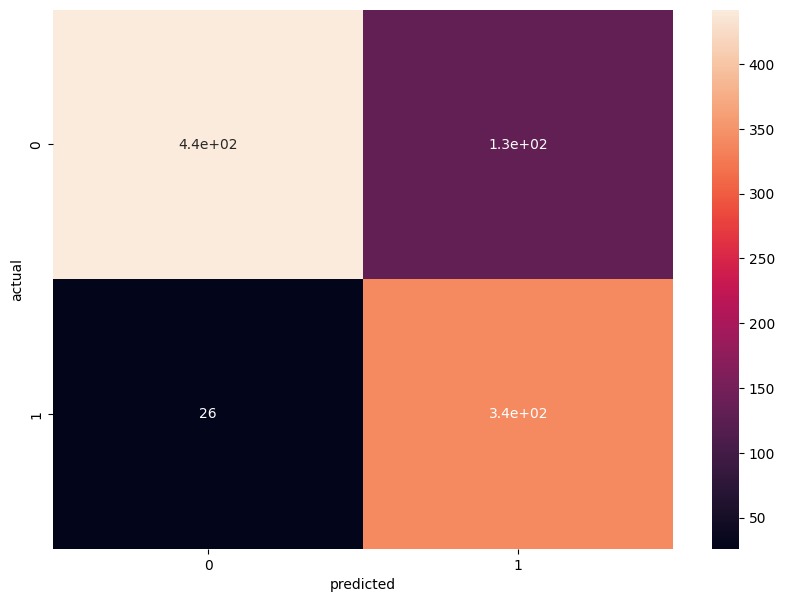

In [16]:
cm = confusion_matrix(LR_pred, y_test)
plt.figure(figsize=(10, 7))

sns.heatmap(cm, annot=True)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

FPR is high
FNR is low

Feature: 0, Score: 2.63152
Feature: 1, Score: -0.15478
Feature: 2, Score: 0.08862
Feature: 3, Score: 0.09458
Feature: 4, Score: -0.13020
Feature: 5, Score: -0.10869
Feature: 6, Score: 0.07205
Feature: 7, Score: -0.18979
Feature: 8, Score: 0.20435
Feature: 9, Score: -0.03145


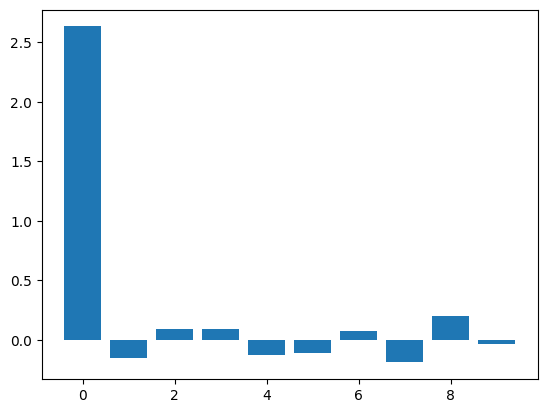

In [17]:
# Feature immportance

importance = LR.coef_[0]
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [18]:
DT = tree.DecisionTreeClassifier()
DT.fit(X_train, y_train)


DecisionTreeClassifier()

In [19]:
DT_pred = DT.predict(X_test)
DT_pred[:5]

array([0, 0, 0, 0, 1])

In [20]:
y_test[:5]

3887    0
4217    1
4184    0
2463    0
3203    1
Name: is_fraud, dtype: int64

In [ ]:

accuracy = accuracy_score(DT_pred, y_test)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.96


In [22]:
print(classification_report(y_test, DT_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       468
           1       0.96      0.96      0.96       471

    accuracy                           0.96       939
   macro avg       0.96      0.96      0.96       939
weighted avg       0.96      0.96      0.96       939



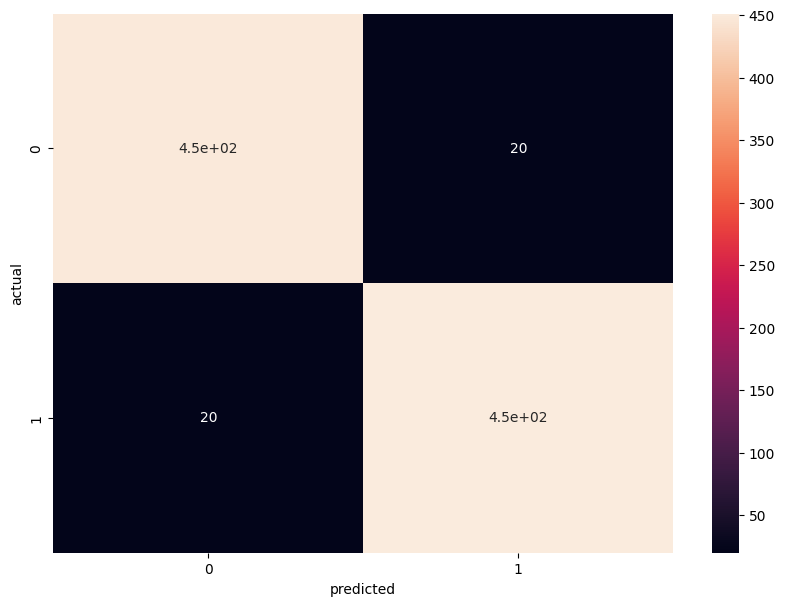

In [23]:
cm = confusion_matrix(DT_pred, y_test)
plt.figure(figsize=(10, 7))

sns.heatmap(cm, annot=True)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

Feature: 0, Score: 0.68845
Feature: 1, Score: 0.00891
Feature: 2, Score: 0.00784
Feature: 3, Score: 0.01462
Feature: 4, Score: 0.00556
Feature: 5, Score: 0.09611
Feature: 6, Score: 0.00112
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.04001
Feature: 9, Score: 0.13737


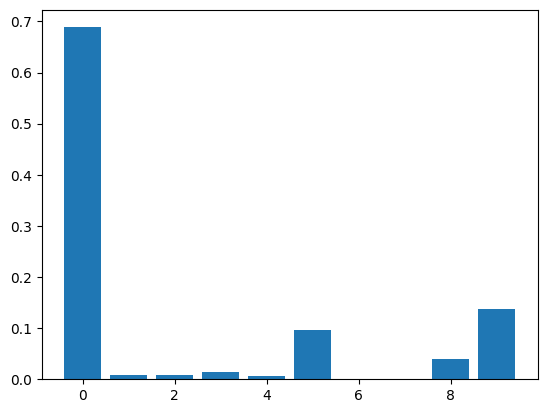

In [27]:
# Feature immportance

importance = DT.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()